In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import os

In [2]:
# Reading the data and splitting the data
df = pd.read_csv('./data/all/data.csv')

# Discarding irrelevant for classification information (keeping only path to load from and label)
df = df[['path', 'borough']]
train_df, test_df = train_test_split(df, random_state = 3, test_size = 0.2)
val_df, test_df = train_test_split(test_df, random_state = 3, test_size = 0.5)

In [3]:
train_df.head()

,path,borough
34833,./data/all/Brooklyn/540593097940529.jpg,Brooklyn
3363,./data/all/Queens/479092496643392.jpg,Queens
8144,./data/all/Manhattan/1674814212725568.jpg,Manhattan
13877,./data/all/Queens/3930874653663554.jpg,Queens
14423,./data/all/Queens/3051687035117658.jpg,Queens


In [5]:
# Defining a custom dataset
class CustomDataset(Dataset):
    def __init__(self, df):                   
        self.data = []
        for index in range(len(df)):                       
          path = df.iloc[index][0]
          category = df.iloc[index][1]             
          self.data.append([path, category])
        self.class_map = {"Bronx" : 0, "Brooklyn": 1,"Manhattan": 2, "Queens": 3, "Staten Island": 4}
        #self.img_dim = (224, 224)
    def __len__(self):                                
        return len(self.data)

    def __getitem__(self, idx):                       
        img_path, class_name = self.data[idx]         
        img = cv2.imread(img_path)                    
        #img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [6]:
train_set = CustomDataset(train_df)
val_set = CustomDataset(val_df)
test_set = CustomDataset(test_df)

In [7]:
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

In [8]:
def Training(dataloader, model, transforms, loss_fn, optimizer, dataset = 'imagenet'):

  train_loss = 0                
  num_batches = len(dataloader)
  model.train()                 

  for batch, (X, y) in enumerate(dataloader):   # For each batch

    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()                       # Zeroing the gradients
    X = transforms(X)
    if dataset != 'imagenet':
        X = X.to(torch.float32)
    output = model(X)                           # Perform a forward pass
    loss = loss_fn(output, y.squeeze())         # Calculate the loss function

    loss.backward()                             # Perform Backpropagation
    optimizer.step()                            # Update the weights

    train_loss += loss.item()                   # Accumulate the error

  train_loss /= num_batches                     # Average error per epoch
  return train_loss

In [9]:
def Validation(dataloader, model, transforms, loss_fn, dataset = 'imagenet'):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()                                 
    val_loss, correct = 0, 0

    with torch.no_grad():                         
        for X, y in dataloader:                   
            X = X.to(device)
            y = y.to(device)
            X = transforms(X)
            if dataset != 'imagenet':
                X = X.to(torch.float32)
            pred = model(X)                       
            val_loss += loss_fn(pred, y.squeeze()).item()   
            correct += (pred.argmax(1) == y.squeeze()).type(torch.float).sum().item()

    val_loss /= num_batches         
    correct /= size
    return val_loss, correct

In [36]:
def Train_Validation(model, transforms, train_loader, val_loader, epochs, loss_function, optimizer, dataset = 'imagenet', name = 'resnet18'):

  val_loss_prev = 1000

  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = Training(train_loader, model, transforms, loss_function, optimizer, dataset)
    print(f"Training Loss: {train_loss:>8f}")
    val_loss, val_acc = Validation(val_loader, model, transforms, loss_function, dataset)

    
    if abs(val_loss_prev - val_loss) < 0.005:            # If the change is very small, early stop training
        print("Early Stopping - Epoch: {}".format(t+1))
        break

    else:                                            
      if val_loss < val_loss_prev :
        string = 'weights_{}.pth'.format(name, epochs)
        torch.save(model.state_dict(), string)
        val_loss_prev = val_loss
        print(f"Validation Loss: {val_loss:>8f} \nValidation Accuracy: {(100*val_acc):>0.1f}% (Model Checkpoint)\n")
      else:
        print(f"Validation Loss: {val_loss:>8f} \nValidation Accuracy: {(100*val_acc):>0.1f}%\n")


  print("Training Done!")

In [11]:
def TransferLearning(model, transforms, train_loader, val_loader, lr = 0.001, epochs = 10, replace = False, tune = False, dataset = 'imagenet', name = 'resnet18'):

  if tune == False:
    for param in model.parameters():    # The pretrained parameters are frozen
      param.requires_grad = False
    num_ftrs = model.fc.in_features     # We replace the fc layer
    model.fc = nn.Linear(num_ftrs, 5)

  elif tune == True:                    # Fine-tuning
    if replace == True:
      num_ftrs = model.fc.in_features    
      model.fc = nn.Linear(num_ftrs, 5)
    for param in model.parameters():   
      param.requires_grad = True

  model = model.to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr)

  Train_Validation(model, transforms, train_loader, val_loader, epochs, loss_fn, optimizer, dataset, name)
  #model.load_state_dict(torch.load('model_weights.pth'))  # After training restore the state of the model and evaluate on test data
  #Testing(model, transforms, test_loader)

In [26]:
def Testing(test_loader, trained_model, transforms, display = True, dataset = 'imagenet'):

    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    trained_model.eval()
    correct = 0

    images = []
    true_labels = []
    pred_labels = []
    counter = 0

    with torch.no_grad():
        for X, y in test_loader:
            if dataset != 'imagenet':
                X = X.to(torch.float32)
            X = X.to(device)
            y = y.to(device)
            X = transforms(X)
            pred = trained_model(X)
            correct += (pred.argmax(1) == y.squeeze()).type(torch.float).sum().item()

            # Finding falsely classified images to display
            if display == True:
                if counter < 10:
                    wrong_indices = ((pred.argmax(1) == y.squeeze())==False).nonzero()
                    if wrong_indices.squeeze().size() == torch.Size([]):
                        continue
                    elif wrong_indices.squeeze().size()[0] >= 10:
                        for i in range(10):
                            #print(counter, 'all')
                            k = wrong_indices[i].item()
                            images.append(X[k].cpu())
                            if y[k].item() == 0:
                                true_labels.append('Bronx')
                            elif y[k].item() == 1:
                                true_labels.append('Brooklyn')
                            elif y[k].item() == 2:
                                true_labels.append('Manhattan')
                            elif y[k].item() == 3:
                                true_labels.append('Queens')
                            elif y[k].item() == 4:
                                true_labels.append('Staten Island')

                            if pred.argmax(1)[k].item() == 0:
                                pred_labels.append('Bronx')
                            elif pred.argmax(1)[k].item() == 1:
                                pred_labels.append('Brooklyn')
                            elif pred.argmax(1)[k].item() == 2:
                                pred_labels.append('Manhattan')
                            elif pred.argmax(1)[k].item() == 3:
                                pred_labels.append('Queens')
                            elif pred.argmax(1)[k].item() == 4:
                                pred_labels.append('Staten Island')

                            counter += 1
                    else:
                        for i in range(wrong_indices.squeeze().size()[0]):
                            k = wrong_indices[i].item()
                            #print(counter, 'none')
                            images.append(X[k].cpu())
                            if y[k].item() == 0:
                                true_labels.append('Bronx')
                            elif y[k].item() == 1:
                                true_labels.append('Brooklyn')
                            elif y[k].item() == 2:
                                true_labels.append('Manhattan')
                            elif y[k].item() == 3:
                                true_labels.append('Queens')
                            elif y[k].item() == 4:
                                true_labels.append('Staten Island')
                            if pred.argmax(1)[k].item() == 0:
                                pred_labels.append('Bronx')
                            elif pred.argmax(1)[k].item() == 1:
                                pred_labels.append('Brooklyn')
                            elif pred.argmax(1)[k].item() == 2:
                                pred_labels.append('Manhattan')
                            elif pred.argmax(1)[k].item() == 4:
                                pred_labels.append('Queens')
                            elif pred.argmax(1)[k].item() == 5:
                                pred_labels.append('Staten Island')
                            counter += 1

        correct /= size
        print("--------------------")
        print(f"Test Accuracy: {(100*correct):>0.1f}%\n")

        # Plotting 5 falsely classified images
        if display == True:
            fig, axs = plt.subplots(2, 5, figsize=(10,4))
            for i in range(2):
                for j in range(5):
                    axs[i, j].imshow(images[i*5+j].to(torch.int32).permute(1,2,0).numpy()[:,:,::-1])
                    string = 'True Label = {}\nAssigned Label = {}'.format(true_labels[i*5+j], pred_labels[i*5+j])
                    axs[i, j].set_title(string, fontsize='x-small')
                    axs[i, j].set_xticks([])
                    axs[i, j].set_yticks([])
            plt.show()

#### DON'T USE THIS (RESNET18)

In [29]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms(antialias=True) # This transformation automatically converts the input data to the expected format
model = resnet18(weights=weights)

In [ ]:
TransferLearning(model, transforms, train_loader, val_loader)

Epoch 1
-------------------------------
Training Loss: 1.508365
Validation Loss: 1.468564 
Validation Accuracy: 37.5% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 1.438599
Validation Loss: 1.419073 
Validation Accuracy: 39.1% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 1.395841
Validation Loss: 1.383420 
Validation Accuracy: 41.7% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 1.366420
Validation Loss: 1.358958 
Validation Accuracy: 42.9% (Model Checkpoint)

Epoch 5
-------------------------------
Training Loss: 1.344477
Validation Loss: 1.342678 
Validation Accuracy: 43.4% (Model Checkpoint)

Epoch 6
-------------------------------
Training Loss: 1.327518
Validation Loss: 1.327121 
Validation Accuracy: 44.1% (Model Checkpoint)

Epoch 7
-------------------------------
Training Loss: 1.314373
Validation Loss: 1.316844 
Validation Accuracy: 44.3% (Model Checkpoint)

Epoch 8
--------------------------

In [ ]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model.load_state_dict(torch.load('model_weights.pth'))
Train_Validation(model, transforms, train_loader, val_loader, 5, loss_fn, optimizer)

Epoch 1
-------------------------------
Training Loss: 1.263591
Validation Loss: 1.269236 
Validation Accuracy: 46.8% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 1.245259
Validation Loss: 1.262386 
Validation Accuracy: 47.5% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 1.233597
Validation Loss: 1.243374 
Validation Accuracy: 47.4% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 1.223313
Validation Loss: 1.248396 
Validation Accuracy: 47.6%

Epoch 5
-------------------------------
Training Loss: 1.220949
Validation Loss: 1.237212 
Validation Accuracy: 47.5% (Model Checkpoint)

Training Done!


In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))
for param in model.parameters():
  param.requires_grad = True

Train_Validation(model, transforms, train_loader, val_loader, 5, loss_fn, optimizer)

Epoch 1
-------------------------------
Training Loss: 1.138963
Validation Loss: 1.105708 
Validation Accuracy: 54.5% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 0.949500
Validation Loss: 1.034358 
Validation Accuracy: 57.9% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 0.802019
Validation Loss: 1.008202 
Validation Accuracy: 60.1% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 0.651941
Validation Loss: 1.036918 
Validation Accuracy: 60.2%

Epoch 5
-------------------------------
Training Loss: 0.487497
Validation Loss: 1.055736 
Validation Accuracy: 61.1%

Training Done!


#### USE THIS (RESNET18)


In [49]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms(antialias=True)
model = resnet18(weights=weights)

In [50]:
TransferLearning(model, transforms, train_loader, val_loader, 0.01, 5, replace = True, tune = True, name = 'resnet18')

Epoch 1
-------------------------------
Training Loss: 1.272441
Validation Loss: 1.154861 
Validation Accuracy: 52.7% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 1.054070
Validation Loss: 1.062836 
Validation Accuracy: 56.1% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 0.909423
Validation Loss: 1.026487 
Validation Accuracy: 57.2% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 0.769626
Validation Loss: 1.033037 
Validation Accuracy: 59.2%

Epoch 5
-------------------------------
Training Loss: 0.613260
Validation Loss: 1.067779 
Validation Accuracy: 58.0%

Training Done!


#### DON'T USE THIS (REGNET)


In [37]:
from torchvision.models import regnet_y_1_6gf, RegNet_Y_1_6GF_Weights
weights = RegNet_Y_1_6GF_Weights.IMAGENET1K_V1
transforms = weights.transforms(antialias=True)
model = regnet_y_1_6gf(weights=weights)

In [ ]:
TransferLearning(model, transforms, train_loader, val_loader)

Epoch 1
-------------------------------
Training Loss: 1.506023
Validation Loss: 1.481848 
Validation Accuracy: 35.9% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 1.449909
Validation Loss: 1.439118 
Validation Accuracy: 37.3% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 1.410691
Validation Loss: 1.406500 
Validation Accuracy: 40.6% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 1.381541
Validation Loss: 1.379590 
Validation Accuracy: 41.5% (Model Checkpoint)

Epoch 5
-------------------------------
Training Loss: 1.359076
Validation Loss: 1.360394 
Validation Accuracy: 42.8% (Model Checkpoint)

Epoch 6
-------------------------------
Training Loss: 1.341741
Validation Loss: 1.346099 
Validation Accuracy: 43.5% (Model Checkpoint)

Epoch 7
-------------------------------
Training Loss: 1.325929
Validation Loss: 1.333329 
Validation Accuracy: 44.2% (Model Checkpoint)

Epoch 8
--------------------------

#### USE THIS (REGNET)


In [17]:
from torchvision.models import regnet_y_1_6gf, RegNet_Y_1_6GF_Weights
weights = RegNet_Y_1_6GF_Weights.IMAGENET1K_V1
transforms = weights.transforms(antialias=True)
model = regnet_y_1_6gf(weights=weights)

In [18]:
TransferLearning(model, transforms, train_loader, val_loader, 0.01, 5, replace = True, tune = True, name = 'regnet')

Epoch 1
-------------------------------
Training Loss: 1.320482
Validation Loss: 1.204859 
Validation Accuracy: 50.2% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 1.118347
Validation Loss: 1.105229 
Validation Accuracy: 54.2% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 0.997433
Validation Loss: 1.057483 
Validation Accuracy: 57.0% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 0.886158
Validation Loss: 1.034785 
Validation Accuracy: 57.7% (Model Checkpoint)

Epoch 5
-------------------------------
Training Loss: 0.768380
Validation Loss: 1.019936 
Validation Accuracy: 59.4% (Model Checkpoint)

Training Done!


#### DON'T USE THIS (RESNET50)


In [25]:
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.IMAGENET1K_V1
transforms = weights.transforms(antialias=True)
model = resnet50(weights=weights)

In [16]:
TransferLearning(model, transforms, train_loader, val_loader, 0.01, 10, False)

Epoch 1
-------------------------------
Training Loss: 1.366665
Validation Loss: 1.300190 
Validation Accuracy: 45.5% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 1.270463
Validation Loss: 1.279088 
Validation Accuracy: 45.9% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 1.241528
Validation Loss: 1.256992 
Validation Accuracy: 47.8% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 1.225265
Validation Loss: 1.317671 
Validation Accuracy: 44.2%

Epoch 5
-------------------------------
Training Loss: 1.214852
Validation Loss: 1.228601 
Validation Accuracy: 48.0% (Model Checkpoint)

Epoch 6
-------------------------------
Training Loss: 1.208872
Validation Loss: 1.218207 
Validation Accuracy: 49.2% (Model Checkpoint)

Epoch 7
-------------------------------
Training Loss: 1.202330
Validation Loss: 1.220219 
Validation Accuracy: 48.8%

Epoch 8
-------------------------------
Training Loss: 1.194185
Validati

In [17]:
model.load_state_dict(torch.load('model_weights_resnet50.pth'))
TransferLearning(model, transforms, train_loader, val_loader, 0.01, 5, True)

Epoch 1
-------------------------------
Training Loss: 1.093184
Validation Loss: 1.034265 
Validation Accuracy: 58.0% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 0.830421
Validation Loss: 0.993607 
Validation Accuracy: 60.3% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 0.578699
Validation Loss: 1.006183 
Validation Accuracy: 62.5%

Epoch 4
-------------------------------
Training Loss: 0.289185
Validation Loss: 1.185670 
Validation Accuracy: 60.3%

Epoch 5
-------------------------------
Training Loss: 0.088274
Validation Loss: 1.352074 
Validation Accuracy: 61.6%

Training Done!


#### USE THIS (RESNET50)


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.IMAGENET1K_V1
transforms = weights.transforms(antialias=True)
model = resnet50(weights=weights)

In [20]:
TransferLearning(model, transforms, train_loader, val_loader, 0.01, 5, replace = True, tune = True, name = 'resnet_50')

Epoch 1
-------------------------------
Training Loss: 1.248253
Validation Loss: 1.151459 
Validation Accuracy: 52.0% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 0.988641
Validation Loss: 1.025481 
Validation Accuracy: 58.0% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 0.770865
Validation Loss: 0.996006 
Validation Accuracy: 60.5% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 0.511587
Validation Loss: 1.041727 
Validation Accuracy: 61.5%

Epoch 5
-------------------------------
Training Loss: 0.230411
Validation Loss: 1.277448 
Validation Accuracy: 58.6%

Training Done!


--------------------
Test Accuracy: 60.5%



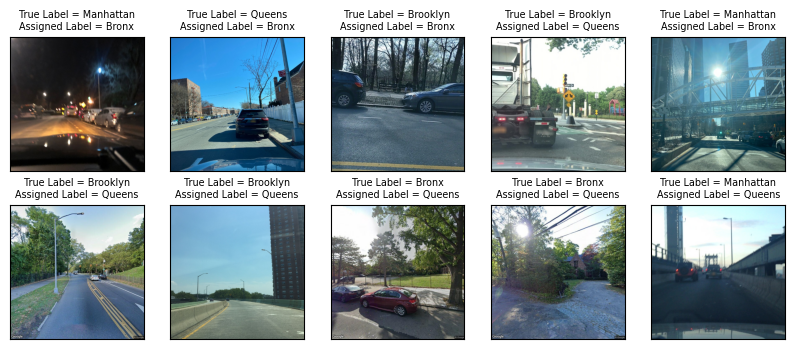

In [27]:
model.load_state_dict(torch.load('model_weights_resnet_50_5.pth'))
Testing(val_loader, model, transforms)

In [45]:
# Loading the architecture
arch = 'resnet18'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
transforms_places = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),])

In [33]:
TransferLearning(model, transforms_places, train_loader, val_loader, 0.01, 5, replace = True, tune = False, dataset = 'places', name = 'resnet18_places_final')

Epoch 1
-------------------------------
Training Loss: 1.372724
Validation Loss: 1.315178 
Validation Accuracy: 44.3% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 1.276602
Validation Loss: 1.258968 
Validation Accuracy: 46.8% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 1.245607
Validation Loss: 1.240220 
Validation Accuracy: 47.9% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 1.226721
Validation Loss: 1.223404 
Validation Accuracy: 48.8% (Model Checkpoint)

Epoch 5
-------------------------------
Training Loss: 1.214531
Validation Loss: 1.214692 
Validation Accuracy: 49.0% (Model Checkpoint)

Training Done!


In [41]:
model.load_state_dict(torch.load('model_weights_resnet18_places_final_5.pth'))
TransferLearning(model, transforms_places, train_loader, val_loader, 0.01, 5, replace = False, tune = True, dataset = 'places', name = 'resnet18_places_final_tune')

Epoch 1
-------------------------------
Training Loss: 1.143450
Validation Loss: 1.096927 
Validation Accuracy: 54.7% (Model Checkpoint)

Epoch 2
-------------------------------
Training Loss: 1.015135
Validation Loss: 1.038711 
Validation Accuracy: 57.7% (Model Checkpoint)

Epoch 3
-------------------------------
Training Loss: 0.912639
Validation Loss: 0.990837 
Validation Accuracy: 59.3% (Model Checkpoint)

Epoch 4
-------------------------------
Training Loss: 0.816580
Validation Loss: 0.961522 
Validation Accuracy: 61.5% (Model Checkpoint)

Epoch 5
-------------------------------
Training Loss: 0.715985
Validation Loss: 0.944855 
Validation Accuracy: 62.1% (Model Checkpoint)

Training Done!


--------------------
Test Accuracy: 62.1%



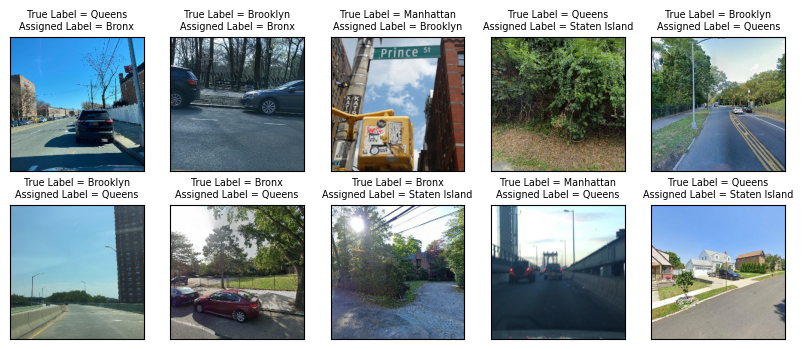

In [56]:
model.load_state_dict(torch.load('model_weights_resnet18_places_final_tune_5.pth'))
Testing(val_loader, model, transforms_places, dataset = 'places')